In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torch_optimizer import Lookahead


from model import KeywordSpottingModel_with_cls
from data_loader import load_speech_commands_dataset, TFDatasetAdapter, load_bg_noise_dataset
from utils import set_memory_GB,print_model_size, log_to_file
from augmentations import add_time_shift_and_align, add_silence
from train_utils import trainig_loop





/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type=

In [2]:
torch.cuda.is_available()

True

In [3]:
set_memory_GB(1)

Memory fraction set to 0.022458079576498518
Memory fraction in GB: 1.0


In [4]:
train_ds, val_ds, test_ds, silence_ds , info = load_speech_commands_dataset()
bg_noise_ds = load_bg_noise_dataset()

2024-09-11 10:20:56.354364: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 10:20:56.695012: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-11 10:20:56.969179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 10:20:57.194275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 10:20:57.260905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attemptin

In [5]:
# maintain seed for repructablity
np.seed = 42
# tf.random.set_seed(42)
torch.manual_seed(0)

In [6]:
label_names = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']
print(label_names)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


In [7]:
augmentations = [
    lambda x: add_time_shift_and_align(x),
]

In [8]:
# Convert the TFDS dataset to a PyTorch Dataset
fixed_length = 16000
n_mfcc = 13
n_fft = 640
hop_length = 320
n_mels = 40
pytorch_train_dataset = TFDatasetAdapter(train_ds, bg_noise_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentation = augmentations,noise_level=0.05)
pytorch_val_dataset = TFDatasetAdapter(val_ds, None, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentation=None)

2024-09-11 10:22:56.208515: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-11 10:22:59.070025: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# #play sound from dataset
# import IPython.display as ipd

# for i in range(10):
#     x, y = pytorch_train_dataset[i]
#     print(label_names[y])
#     ipd.display(ipd.Audio(x.numpy(), rate=16000))
#     # print(x.shape)

In [10]:
# Create a DataLoader to feed the data into the model
batch_size = 32
train_loader = DataLoader(pytorch_train_dataset, batch_size=batch_size, shuffle=True,num_workers=4,prefetch_factor=2)
val_loader = DataLoader(pytorch_val_dataset, batch_size=batch_size, shuffle=False,num_workers=4,prefetch_factor=2)

# Training loop

# With L2 regulariztion AND Droput layer

In [16]:
# Initialize model, loss function, and optimizer
input_dim = 39  # Number of MFCC features
d_model = 52  # Number of frames + 1 for CLS token
d_state = 16
d_conv = 4
expand = 2

model = KeywordSpottingModel_with_cls(input_dim=input_dim, d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, label_names=label_names, num_mamba_layers=1,dropout_rate=0.1).to("cuda")

# class_weights = class_weights / np.sum(class_weights)  # Normalize class weights
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to("cuda")  # Convert to tensor
criterion = nn.CrossEntropyLoss().to("cuda")  # Loss function with class weights
base_optimizer = optim.Adam(model.parameters(), lr=0.0024, weight_decay=2.80475e-05) # weight_decay for L2 regulariztopn

from torch_optimizer import Lookahead

optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)  # Wrap around Adam


In [17]:
# Adding learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [18]:



# Training loop
num_epochs = 100

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

train_accuracies, val_accuracies, train_losses, val_losses = trainig_loop(model, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler)





100%|████████████████████████████████████████████████████████████████████| 962/962 [00:35<00:00, 26.89it/s]

Epoch 1/100, Training Loss: 1.2618612498044968, Training Accuracy: 55.152913646852355%


Validation Loss: 0.7420008639837133, Validation Accuracy: 74.66918714555766%
Learning rate after epoch 1: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:32<00:00, 29.78it/s]

Epoch 2/100, Training Loss: 0.6938308633383743, Training Accuracy: 76.35607267054503%


Validation Loss: 0.5407225469063068, Validation Accuracy: 82.14960842560086%
Learning rate after epoch 2: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:31<00:00, 30.65it/s]

Epoch 3/100, Training Loss: 0.578052438021078, Training Accuracy: 80.47385355390165%


Validation Loss: 0.42850953083613824, Validation Accuracy: 85.57926005941128%
Learning rate after epoch 3: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:30<00:00, 31.86it/s]

Epoch 4/100, Training Loss: 0.4953640595450223, Training Accuracy: 83.43462575969319%


Validation Loss: 0.3890810827242917, Validation Accuracy: 86.33540372670808%
Learning rate after epoch 4: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:30<00:00, 31.98it/s]

Epoch 5/100, Training Loss: 0.45007517202728253, Training Accuracy: 84.58188436413273%


Validation Loss: 0.36154788334307997, Validation Accuracy: 88.1177423710505%
Learning rate after epoch 5: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:29<00:00, 32.71it/s]

Epoch 6/100, Training Loss: 0.4223287489706662, Training Accuracy: 85.75514316357372%


Validation Loss: 0.3641802457899883, Validation Accuracy: 87.84769106130165%
Learning rate after epoch 6: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:30<00:00, 31.98it/s]

Epoch 7/100, Training Loss: 0.40360400347104936, Training Accuracy: 86.51239884299132%


Validation Loss: 0.3251744829567856, Validation Accuracy: 89.413988657845%
Learning rate after epoch 7: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:29<00:00, 32.41it/s]

Epoch 8/100, Training Loss: 0.3846365301221175, Training Accuracy: 87.11690337677533%


Validation Loss: 0.3243152544159314, Validation Accuracy: 89.38698352687011%
Learning rate after epoch 8: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:29<00:00, 32.47it/s]

Epoch 9/100, Training Loss: 0.3728233448630528, Training Accuracy: 87.41915564366732%


Validation Loss: 0.34712478544177683, Validation Accuracy: 88.30677828787469%
Learning rate after epoch 9: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:27<00:00, 35.16it/s]

Epoch 10/100, Training Loss: 0.3824083043994254, Training Accuracy: 86.99990249926874%


Validation Loss: 0.3321178765517884, Validation Accuracy: 88.92789630029705%
Learning rate after epoch 10: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:27<00:00, 35.44it/s]

Epoch 11/100, Training Loss: 0.3717610742780622, Training Accuracy: 87.47440605804543%


Validation Loss: 0.27981974868553466, Validation Accuracy: 90.65622468268971%
Learning rate after epoch 11: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:29<00:00, 32.76it/s]

Epoch 12/100, Training Loss: 0.376690122610628, Training Accuracy: 87.34440508303813%


Validation Loss: 0.2868050794470413, Validation Accuracy: 90.38617337294086%
Learning rate after epoch 12: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:30<00:00, 32.00it/s]

Epoch 13/100, Training Loss: 0.3626865340385145, Training Accuracy: 87.57840683805128%


Validation Loss: 0.27385518600329245, Validation Accuracy: 90.8452605995139%
Learning rate after epoch 13: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:27<00:00, 34.69it/s]

Epoch 14/100, Training Loss: 0.3309922594646778, Training Accuracy: 88.7874159056193%


Validation Loss: 0.26608250219503354, Validation Accuracy: 91.08830677828787%
Learning rate after epoch 14: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:27<00:00, 35.11it/s]

Epoch 15/100, Training Loss: 0.3193851872047181, Training Accuracy: 89.34967012252592%


Validation Loss: 0.26804265521209814, Validation Accuracy: 90.79125033756414%
Learning rate after epoch 15: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:25<00:00, 37.38it/s]

Epoch 16/100, Training Loss: 0.330598874443565, Training Accuracy: 88.73216549124119%


Validation Loss: 0.27672191333539525, Validation Accuracy: 90.38617337294086%
Learning rate after epoch 16: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:27<00:00, 34.84it/s]

Epoch 17/100, Training Loss: 0.3169724497878285, Training Accuracy: 89.31066983002373%


Validation Loss: 0.27364518255766096, Validation Accuracy: 91.19632730218741%
Learning rate after epoch 17: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:27<00:00, 35.00it/s]

Epoch 18/100, Training Loss: 0.32284509382266824, Training Accuracy: 89.02466768500764%


Validation Loss: 0.2577528177664198, Validation Accuracy: 91.16932217121253%
Learning rate after epoch 18: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:27<00:00, 35.06it/s]

Epoch 19/100, Training Loss: 0.33015566909774796, Training Accuracy: 88.96941727062953%


Validation Loss: 0.2681038840513291, Validation Accuracy: 90.73724007561437%
Learning rate after epoch 19: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:28<00:00, 33.64it/s]

Epoch 20/100, Training Loss: 0.32062934186859465, Training Accuracy: 89.12216841626312%


Validation Loss: 0.2540951121983857, Validation Accuracy: 91.49338374291115%
Learning rate after epoch 20: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:31<00:00, 30.24it/s]

Epoch 21/100, Training Loss: 0.30233840161659553, Training Accuracy: 89.50242126815951%


Validation Loss: 0.24280608663785047, Validation Accuracy: 91.52038887388603%
Learning rate after epoch 21: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:28<00:00, 33.87it/s]

Epoch 22/100, Training Loss: 0.29373400266477817, Training Accuracy: 90.09717572881797%


Validation Loss: 0.2375381620408132, Validation Accuracy: 92.06049149338374%
Learning rate after epoch 22: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:29<00:00, 33.11it/s]

Epoch 23/100, Training Loss: 0.2937355090800107, Training Accuracy: 90.07767558256687%


Validation Loss: 0.22960711858267413, Validation Accuracy: 92.03348636240885%
Learning rate after epoch 23: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:25<00:00, 37.68it/s]

Epoch 24/100, Training Loss: 0.28576590457985374, Training Accuracy: 90.39942799570997%


Validation Loss: 0.2505936248806016, Validation Accuracy: 91.81744531460977%
Learning rate after epoch 24: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:26<00:00, 35.92it/s]

Epoch 25/100, Training Loss: 0.3799043226127441, Training Accuracy: 87.41915564366732%


Validation Loss: 0.3392143904006687, Validation Accuracy: 88.71185525249797%
Learning rate after epoch 25: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:27<00:00, 34.69it/s]

Epoch 26/100, Training Loss: 0.3912909820389289, Training Accuracy: 86.87965159738698%


Validation Loss: 0.37020024438870364, Validation Accuracy: 88.03672697812584%
Learning rate after epoch 26: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:26<00:00, 36.23it/s]

Epoch 27/100, Training Loss: 0.3721123664347521, Training Accuracy: 87.61090708180312%


Validation Loss: 0.3226569964197175, Validation Accuracy: 89.49500405076965%
Learning rate after epoch 27: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:27<00:00, 35.22it/s]

Epoch 28/100, Training Loss: 0.33522572463258266, Training Accuracy: 88.995417465631%


Validation Loss: 0.3075776335237355, Validation Accuracy: 90.03510667026735%
Learning rate after epoch 28: [0.00023999999999999998]
Early stopping triggered
Stopping training at epoch 28 due to early stopping


In [19]:
# load test data
pytorch_test_dataset = TFDatasetAdapter(test_ds,None, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentation=None)
test_loader = DataLoader(pytorch_test_dataset, batch_size=batch_size, shuffle=False,num_workers=4,prefetch_factor=2)

# Evaluate the model on the test set
accuracy = 0
total = 0
model.eval()

with torch.no_grad():
    for audio, labels in test_loader:
        audio, labels = audio.to("cuda"), labels.to("cuda")
        outputs = model(audio)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
test_accuracy = 100 * accuracy / total
print(f'Test Accuracy: {test_accuracy}%')





2024-09-11 12:27:31.882330: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test Accuracy: 88.63524791359843%


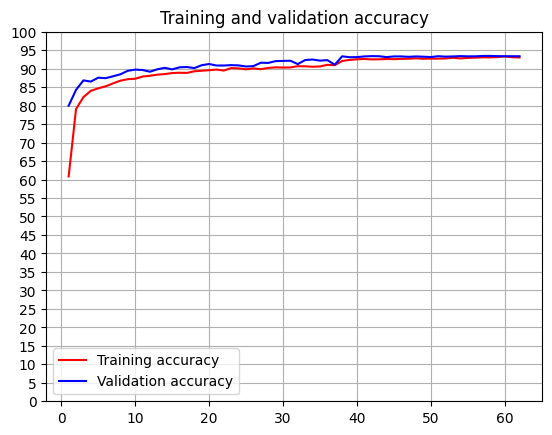

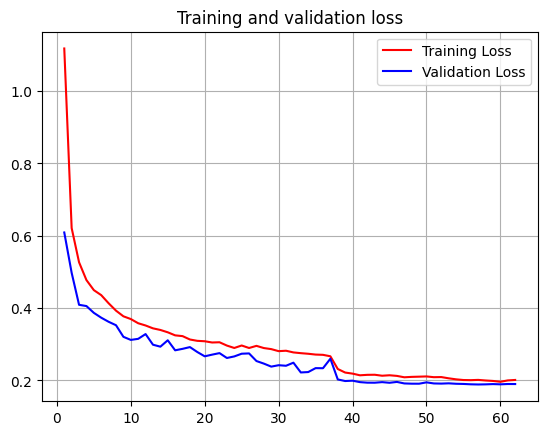

In [15]:
from utils import plot_learning_curves

plot_learning_curves(train_accuracies, val_accuracies, train_losses, val_losses)

In [23]:
import pandas as pd
from utils import compute_inference_GPU_mem
#save model size(macs, params) and accuracy
macs, params = print_model_size(model,input_size=torch.randn(batch_size, input_dim, d_model-1).to("cuda"))
macs = macs/1e9
accuracy = test_accuracy
data = {'Model': ['KeywordSpottingModel_RSM_Norm_0-1-2_order_cls_bgnoise'], 'GMACs': [macs], 'Params': [params], 'Accuracy': [accuracy]}
model_config = {'input_dim': input_dim, 'd_model': d_model, 'd_state': d_state, 'd_conv': d_conv, 'expand': expand}
data.update(model_config)
inf_GPU_mem = compute_inference_GPU_mem(model, input=torch.randn(1, input_dim, d_model-1).to("cuda"))
#inference macs and params
inf_macs, inf_params = print_model_size(model,input_size=torch.randn(1, input_dim, d_model-1).to("cuda"))
inference_data = {'Inference CUDA Mem in MB': [inf_GPU_mem], 'Inference GMACs': [inf_macs/1e9], 'Inference Params': [inf_params]}
data.update(inference_data)
df = pd.DataFrame(data, index=[0])
df.to_csv('results.csv', mode='a', header=False)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Customize rule calculate_MAMBA_flops() <class 'mamba_ssm.modules.mamba_simple.Mamba'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.

MACs: 153694008.0 Which are 0.153694008 Giga-MACs, Params: 41716.0

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Customize rule calculate_MAMBA_flops() <class 'mamba_ssm.modules.mamba_simple.Mamba'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.

MACs: 5620524.0 Which are 0.005620524 Giga-MACs, Params: 41716.0



In [ ]:
with torch.profiler.profile(with_flops=True) as prof:
    model(torch.randn(32, input_dim, d_model-1).to("cuda"))

# Print FLOPs
print(prof.key_averages().table(sort_by="flops"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total KFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                               aten::mm         4.65%     342.751us         6.26%     461.124us      92.225us      30.080us        20.37%      30.080us       6.016us             5     74457.344  
                                              aten::mul         0.91%      66.738us         1.22%      89.993us      44.996us       6.048us         4.1